In [15]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from alibi.explainers import AnchorTabular
from alibi.datasets import fetch_adult

In [27]:
adult = fetch_adult()
adult.keys()

dict_keys(['data', 'target', 'feature_names', 'target_names', 'category_map'])

In [28]:
data = adult.data
target = adult.target
feature_names = adult.feature_names
category_map = adult.category_map

In [29]:
from alibi.utils.data import gen_category_map

In [30]:
np.random.seed(0)
data_perm = np.random.permutation(np.c_[data, target])
data = data_perm[:,:-1]
target = data_perm[:,-1]

In [33]:
data

array([[27,  4,  4, ...,  0, 44,  9],
       [27,  4,  1, ...,  0, 40,  9],
       [25,  4,  0, ...,  0, 40,  9],
       ...,
       [23,  4,  4, ...,  0, 40,  9],
       [45,  2,  2, ...,  0, 45,  9],
       [25,  4,  4, ...,  0, 48,  9]])

In [34]:
target

array([0, 0, 0, ..., 0, 1, 0])

In [35]:
data_perm

array([[27,  4,  4, ..., 44,  9,  0],
       [27,  4,  1, ..., 40,  9,  0],
       [25,  4,  0, ..., 40,  9,  0],
       ...,
       [23,  4,  4, ..., 40,  9,  0],
       [45,  2,  2, ..., 45,  9,  1],
       [25,  4,  4, ..., 48,  9,  0]])

In [36]:
idx = 30000
X_train,Y_train = data[:idx,:], target[:idx]
X_test, Y_test = data[idx+1:,:], target[idx+1:]

In [37]:
X_train.shape,Y_train.shape

((30000, 12), (30000,))

In [38]:
X_test.shape, Y_test.shape

((2560, 12), (2560,))

In [39]:
ordinal_features = [x for x in range(len(feature_names)) if x not in list(category_map.keys())]

In [40]:
ordinal_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                      ('scaler', StandardScaler())])

In [41]:
categorical_features = list(category_map.keys())

In [42]:
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])


In [43]:
preprocessor = ColumnTransformer(transformers=[('num', ordinal_transformer, ordinal_features),
                                               ('cat', categorical_transformer, categorical_features)])

In [44]:
preprocessor.fit(X_train)


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 [0, 8, 9, 10]),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 [1, 2, 3, 4, 5, 6, 7, 11])])

In [46]:
np.random.seed(0)
clf = RandomForestClassifier(n_estimators=50)

In [47]:
clf

RandomForestClassifier(n_estimators=50)

In [48]:
clf.fit(preprocessor.transform(X_train), Y_train)

RandomForestClassifier(n_estimators=50)

In [49]:
clf

RandomForestClassifier(n_estimators=50)

In [50]:
predict_fn = lambda x: clf.predict(preprocessor.transform(x))

In [51]:
print('Train accuracy: ', accuracy_score(Y_train, predict_fn(X_train)))

Train accuracy:  0.9655333333333334


In [52]:
print('Test accuracy: ', accuracy_score(Y_test, predict_fn(X_test)))


Test accuracy:  0.855859375


In [53]:
# Initialize and fit anchor explainer for tabular data

In [54]:
explainer = AnchorTabular(predict_fn, feature_names, categorical_names=category_map, seed=1)

In [55]:
explainer

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': 1}}
)

In [56]:
explainer.explanations

['local']

In [57]:
explainer.fit(X_train, disc_perc=[25, 50, 75])

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': 1, 'disc_perc': [25, 50, 75]}}
)

In [58]:
idx = 0
class_names = adult.target_names
print('Prediction: ', class_names[explainer.predictor(X_test[idx].reshape(1, -1))[0]])

Prediction:  <=50K


In [59]:
explanation = explainer.explain(X_test[idx], threshold=0.95)

In [61]:
explanation.name

'AnchorTabular'

In [62]:
print('Anchor: %s' % (' AND '.join(explanation.anchor)))

Anchor: Marital Status = Separated AND Sex = Female


In [63]:
print('Precision: %.2f' % explanation.precision)

Precision: 0.95


In [64]:
print('Coverage: %.2f' % explanation.coverage)

Coverage: 0.11


In [65]:
idx = 6
class_names = adult.target_names
print('Prediction: ', class_names[explainer.predictor(X_test[idx].reshape(1, -1))[0]])

Prediction:  >50K


In [66]:
explanation = explainer.explain(X_test[idx], threshold=0.95)

Could not find an result satisfying the 0.95 precision constraint. Now returning the best non-eligible result.


In [67]:
print('Anchor: %s' % (' AND '.join(explanation.anchor)))

Anchor: Capital Loss > 0.00 AND Relationship = Husband AND Marital Status = Married AND Age > 37.00 AND Race = White AND Sex = Male AND Country = United-States


In [68]:
print('Precision: %.2f' % explanation.precision)

Precision: 0.72


In [69]:
print('Coverage: %.2f' % explanation.coverage)

Coverage: 0.02


In [70]:
# the above result does not display the explanation due to class imbalance in data

In [71]:
# low earners sample proportion is relatively smaller than high earners

In [72]:
# Now let's have a look at the movie sentiment dataset for explanation

In [87]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
#import spacy
from alibi.explainers import AnchorText
from alibi.datasets import fetch_movie_sentiment
#from alibi.utils.download import spacy_model

In [81]:
!pip install spacy

In [88]:
movies = fetch_movie_sentiment()
movies.keys()

dict_keys(['data', 'target', 'target_names'])

In [89]:
data = movies.data
labels = movies.target
target_names = movies.target_names


In [90]:
data

['simplistic , silly and tedious .',
 "it's so laddish and juvenile , only teenage boys could possibly find it funny .",
 'exploitative and largely devoid of the depth or sophistication that would make watching such a graphic treatment of the crimes bearable .',
 '[garbus] discards the potential for pathological study , exhuming instead , the skewed melodrama of the circumstantial situation .',
 'a visually flashy but narratively opaque and emotionally vapid exercise in style and mystification .',
 "the story is also as unoriginal as they come , already having been recycled more times than i'd care to count .",
 "about the only thing to give the movie points for is bravado -- to take an entirely stale concept and push it through the audience's meat grinder one more time .",
 'not so much farcical as sour .',
 'unfortunately the story and the actors are served with a hack script .',
 'all the more disquieting for its relatively gore-free allusions to the serial murders , but it falls do

In [91]:
labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [92]:
target_names

['negative', 'positive']

In [102]:
train, test, train_labels, test_labels = train_test_split(data, labels, test_size=.2, random_state=42)
train, test, train_labels, test_labels

(['the french are rather good at this kind of thing , unlike the americans , who have a passion for musketeers , only to spoof them .',
  "the work of an exhausted , desiccated talent who can't get out of his own way .",
  'sandra nettelbeck beautifully orchestrates the transformation of the chilly , neurotic , and self-absorbed martha as her heart begins to open .',
  "because eight legged freaks is partly an homage to them , tarantula and other low- budget b-movie thrillers of the 1950s and '60s , the movie is a silly ( but not sophomoric ) romp through horror and hellish conditions .",
  'all i can say is fuhgeddaboutit .',
  'unfortunately , heartbreak hospital wants to convey the same kind of haughtiness in its own sketchy material but this territory has already been explored previously with better aplomb and sardonic wit .',
  "a bizarre piece of work , with premise and dialogue at the level of kids' television and plot threads as morose as teen pregnancy , rape and suspected mur

In [103]:
train, val, train_labels, val_labels = train_test_split(train, train_labels, test_size=.1, random_state=42)
train, val, train_labels, val_labels

(['rare birds has more than enough charm to make it memorable .',
  'mr . parker has brilliantly updated his source and grasped its essence , composing a sorrowful and hilarious tone poem about alienated labor , or an absurdist workplace sitcom .',
  "shadyac shoots his film like an m . night shyamalan movie , and he frequently maintains the same snail's pace ; he just forgot to add any genuine tension .",
  'diaz wears out her welcome in her most charmless performance',
  'a loud , brash and mainly unfunny high school comedy .',
  "adaptation's success in engaging the audience in the travails of creating a screenplay is extraordinary .",
  'drives for the same kind of bittersweet , conciliatory tone that three seasons achieved but loses its way in rhetorical excess and blatant sentimentality .',
  'a fine production with splendid singing by angela gheorghiu , ruggero raimondi , and roberto alagna .',
  'comes across as a relic from a bygone era , and its convolutions . . . feel silly 

In [104]:
train_labels = np.array(train_labels)
train_labels

array([1, 1, 0, ..., 0, 0, 1])

In [105]:
test_labels = np.array(test_labels)
test_labels

array([0, 1, 0, ..., 1, 1, 1])

In [97]:
val_labels = np.array(val_labels)

In [106]:
val_labels

[0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,


In [107]:
vectorizer = CountVectorizer(min_df=1)
vectorizer.fit(train)

CountVectorizer()

In [108]:
np.random.seed(0)
clf = LogisticRegression(solver='liblinear')
clf.fit(vectorizer.transform(train), train_labels)

LogisticRegression(solver='liblinear')

In [109]:
predict_fn = lambda x: clf.predict(vectorizer.transform(x))

In [113]:
preds_train = predict_fn(train)
preds_train

array([1, 1, 0, ..., 0, 0, 1])

In [114]:
preds_val = predict_fn(val)
preds_val

array([0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,

In [115]:
preds_test = predict_fn(test)
preds_test

array([0, 1, 0, ..., 1, 1, 1])

In [116]:
print('Train accuracy', accuracy_score(train_labels, preds_train))

Train accuracy 0.9801624284382905


In [117]:
print('Validation accuracy', accuracy_score(val_labels, preds_val))

Validation accuracy 0.7544910179640718


In [118]:
print('Test accuracy', accuracy_score(test_labels, preds_test))

Test accuracy 0.7589841878294202


In [126]:
# Anchor explanations for fashion MNIST

In [127]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from alibi.explainers import AnchorImage

In [128]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)

x_train shape: (60000, 28, 28) y_train shape: (60000,)


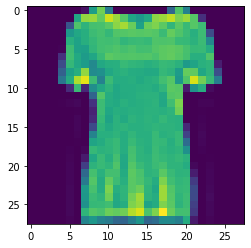

In [130]:
idx = 10
plt.imshow(x_train[idx]);

In [131]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [132]:
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)


x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)


In [133]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

y_train shape: (60000, 10) y_test shape: (10000, 10)


In [134]:
#Define CNN model

In [135]:
def model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(10, activation='softmax')(x)

    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn

In [136]:
cnn = model()
cnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)          0     

In [137]:
cnn.fit(x_train, y_train, batch_size=64, epochs=3)


Epoch 1/3
938/938 [==============================] - 48s 50ms/step - loss: 0.7943 - accuracy: 0.7065
Epoch 2/3
938/938 [==============================] - 58s 62ms/step - loss: 0.4086 - accuracy: 0.8517
Epoch 3/3
938/938 [==============================] - 57s 61ms/step - loss: 0.3702 - accuracy: 0.8665


In [138]:
# Evaluate the model on test set
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

Test accuracy:  0.8906000256538391


In [139]:
# Function to generate rectangular superpixels for a given image

In [140]:
def superpixel(image, size=(4, 7)):
    segments = np.zeros([image.shape[0], image.shape[1]])
    row_idx, col_idx = np.where(segments == 0)
    for i, j in zip(row_idx, col_idx):
        segments[i, j] = int((image.shape[1]/size[1]) * (i//size[0]) + j//size[1])
    return segments

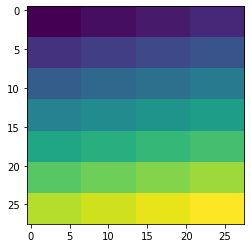

In [141]:
segments = superpixel(x_train[idx])
plt.imshow(segments);


In [142]:
# prediction function

In [143]:
predict_fn = lambda x: cnn.predict(x)

In [144]:
#Initialize anchor image explainer

In [145]:
image_shape = x_train[idx].shape
explainer = AnchorImage(predict_fn, image_shape, segmentation_fn=superpixel)

In [146]:
# Explain a prediction

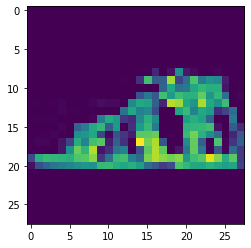

In [148]:
i = 11
image = x_test[i]
plt.imshow(image[:,:,0]);

In [149]:
cnn.predict(image.reshape(1, 28, 28, 1)).argmax()

5

In [151]:
#Label Description

#0 -T-shirt/top
#1 -Trouser
#2 -Pullover
#3 -Dress
#4 - Coat
#5 - Sandal
#6 - Shirt
#7 - Sneaker
#8 - Bag
#9 - Ankle boot

In [152]:
#Generate explanation:

In [153]:
explanation = explainer.explain(image, threshold=.95, p_sample=.8, seed=0)

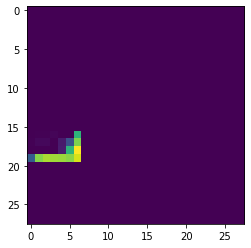

In [154]:
plt.imshow(explanation.anchor[:,:,0]);

In [156]:
print(explanation.anchor)

[[[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]


In [157]:
explanation.coverage

0.4986

In [159]:
explanation.meta

{'name': 'AnchorImage',
 'type': ['blackbox'],
 'explanations': ['local'],
 'params': {'custom_segmentation': True,
  'segmentation_kwargs': None,
  'p_sample': 0.8,
  'seed': None,
  'image_shape': (28, 28, 1),
  'segmentation_fn': 'custom',
  'threshold': 0.95,
  'delta': 0.1,
  'tau': 0.15,
  'batch_size': 100,
  'coverage_samples': 10000,
  'beam_size': 1,
  'stop_on_first': False,
  'max_anchor_size': None,
  'min_samples_start': 100,
  'n_covered_ex': 10,
  'binary_cache_size': 10000,
  'cache_margin': 1000,
  'verbose': False,
  'verbose_every': 1,
  'kwargs': {'seed': 0}}}

In [160]:
explanation.name

'AnchorImage'

In [161]:
explanation.params

{'custom_segmentation': True,
 'segmentation_kwargs': None,
 'p_sample': 0.8,
 'seed': None,
 'image_shape': (28, 28, 1),
 'segmentation_fn': 'custom',
 'threshold': 0.95,
 'delta': 0.1,
 'tau': 0.15,
 'batch_size': 100,
 'coverage_samples': 10000,
 'beam_size': 1,
 'stop_on_first': False,
 'max_anchor_size': None,
 'min_samples_start': 100,
 'n_covered_ex': 10,
 'binary_cache_size': 10000,
 'cache_margin': 1000,
 'verbose': False,
 'verbose_every': 1,
 'kwargs': {'seed': 0}}

In [162]:
explanation.precision

1.0

In [163]:
explanation.raw

{'feature': [16],
 'mean': [1.0],
 'precision': [1.0],
 'coverage': [0.4986],
 'examples': [{'covered_true': [array([[[0.0000000e+00],
            [0.0000000e+00],
            [0.0000000e+00],
            [0.0000000e+00],
            [0.0000000e+00],
            [0.0000000e+00],
            [0.0000000e+00],
            [0.0000000e+00],
            [0.0000000e+00],
            [0.0000000e+00],
            [0.0000000e+00],
            [0.0000000e+00],
            [0.0000000e+00],
            [0.0000000e+00],
            [0.0000000e+00],
            [0.0000000e+00],
            [0.0000000e+00],
            [0.0000000e+00],
            [0.0000000e+00],
            [0.0000000e+00],
            [0.0000000e+00],
            [0.0000000e+00],
            [0.0000000e+00],
            [0.0000000e+00],
            [0.0000000e+00],
            [0.0000000e+00],
            [0.0000000e+00],
            [0.0000000e+00]],
    
           [[0.0000000e+00],
            [0.0000000e+00],
            [0.000

In [164]:
explanation.segments

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,  3.,
         3.,  3.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,  3.,
         3.,  3.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,  3.,
         3.,  3.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,  3.,
         3.,  3.],
       [ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  5.,  5.,  5.,  5.,  5.,  5.,
         5.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  7.,  7.,  7.,  7.,  7.,
         7.,  7.],
       [ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  5.,  5.,  5.,  5.,  5.,  5.,
         5.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  7.,  7.,  7.,  7.,  7.,
         7.,  7.],
       [ 4

In [165]:
explanation.type

['blackbox']